In [1]:
from datetime import datetime

from pathlib import Path

import numpy as np
from scipy.stats import lognorm
import pandas as pd

from astropy import stats
import astropy.units as u
from astropy.io import fits
from astropy.visualization import hist

from matplotlib import style
style.use('ggplot')
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
#%matplotlib widget

In [2]:
rootdir = Path("./data")
# use find to make this csv list
with open(rootdir / "reanalyze_csvs_2024.txt") as f:
    csvs = f.readlines()

# loop through the csv files and read them with pandas
frames = []
for csv in csvs:
    frames.append(pd.read_csv(rootdir / csv.rstrip()))

# now concat each frame into one big frame containing all of the data
data = pd.concat(frames)

In [3]:
g = data.groupby('wfs')
g.wfs.describe()

,count,unique,top,freq
wfs,,,,
binospec,71797,1,binospec,71797
f5,1835,1,f5,1835
mmirs,4858,1,mmirs,4858
newf9,341,1,newf9,341


In [4]:
# re-calculate the seeing using updated spot FWHM for binospec. filter out any NaN values...
#fixed_list = []
#for wfskey, group in g:
#    wfs = wfs_systems[wfskey]
#    group = g.get_group(wfskey)
#    #group.apply(seeing, axis=1, args=(wfs,))
#    group['fixed_raw_seeing'], group['fixed_seeing'] = seeing(group, wfs)
#    fixed_list.append(group)
#fixed = pd.concat(fixed_list)
#fixed.rename(index=str, columns={"seeing": "orig_seeing", "raw seeing": "orig_raw_seeing"}, inplace=True)
#fixed.rename(index=str, columns={"fixed_seeing": "seeing", "fixed_raw_seeing": "raw seeing"}, inplace=True)
fixed = data[np.isfinite(data['seeing'])]
fixed = fixed[fixed['fwhm'] > 0.]
fixed = fixed[fixed['seeing'] > 0.]
fixed = fixed[fixed['seeing'] < 4.]
#fixed = fixed[fixed['time'] < "2020-12-31"]

In [5]:
fixed.sort_values(by='time')

,time,wfs,file,exptime,airmass,az,el,osst,outt,chamt,...,xcen,ycen,seeing,raw_seeing,vlt_seeing,raw_vlt_seeing,ellipticity,fwhm,wavefront_rms,residual_rms
0,2024-01-01T01:26:46.639000,f5,f5wfs_20231231-182659.fits,10.0,1.0148,49.247566,80.192147,3.5,3.49,3.8,...,287.001228,237.002808,1.557176,1.570963,1.303328,1.314868,0.103582,9.041164,1858.382632,1783.582759
1,2024-01-01T01:27:23.161000,f5,f5wfs_20231231-182735.fits,10.0,1.0145,48.832940,80.288824,3.6,3.50,3.8,...,289.993326,239.001835,1.153173,1.163177,1.030648,1.039589,0.107748,7.227431,552.122653,1449.107094
2,2024-01-01T01:27:57.174000,f5,f5wfs_20231231-182809.fits,10.0,1.0143,48.441938,80.377670,3.5,3.50,3.7,...,292.001077,239.003331,1.499831,1.512663,1.304600,1.315761,0.131337,8.784542,310.480210,1653.083920
3,2024-01-01T02:31:15.867000,f5,f5wfs_20231231-193133.fits,15.0,2.3422,53.693660,25.273554,2.4,2.42,2.6,...,235.999518,230.997047,1.175051,1.958084,1.013321,1.688579,0.128990,10.722039,1039.048395,1708.357034
4,2024-01-01T02:32:03.930000,f5,f5wfs_20231231-193220.fits,15.0,2.3305,53.750427,25.409424,2.3,2.40,2.6,...,234.001143,229.995996,1.182739,1.964981,1.014815,1.685996,0.083656,10.751632,1210.657139,1914.009754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
740,2024-12-30T13:13:02.125000,binospec,wfs_ff_cal_img_2024.12.30T131302.125.fits,40.0,1.2522,214.786776,52.999000,8.5,8.40,8.7,...,255.991980,252.014004,0.842325,0.964015,0.804969,0.921263,0.196146,5.437387,246.728192,1544.219147
741,2024-12-30T13:13:45.315000,binospec,wfs_ff_cal_img_2024.12.30T131345.315.fits,40.0,1.2538,215.082634,52.900885,8.5,8.39,8.7,...,254.997473,252.989469,0.843339,0.965915,0.789096,0.903788,0.078753,5.444810,254.891865,1429.881770
742,2024-12-30T13:14:28.516000,binospec,wfs_ff_cal_img_2024.12.30T131428.516.fits,40.0,1.2552,215.336704,52.815494,8.5,8.41,8.6,...,257.992675,252.010364,1.023386,1.172917,0.954420,1.093874,0.121762,6.250442,253.987151,1515.348633
743,2024-12-30T13:15:11.756000,binospec,wfs_ff_cal_img_2024.12.30T131511.756.fits,40.0,1.2566,215.586675,52.730662,8.5,8.39,8.7,...,258.010013,251.004715,0.833625,0.956068,0.781191,0.895932,0.153029,5.406332,318.752520,1541.032021


In [6]:
# create a date-time index so we can group and analyze the data by timestamps
fixed = fixed.set_index(pd.DatetimeIndex(fixed['time'], name='ut'))

<Figure size 800x500 with 0 Axes>

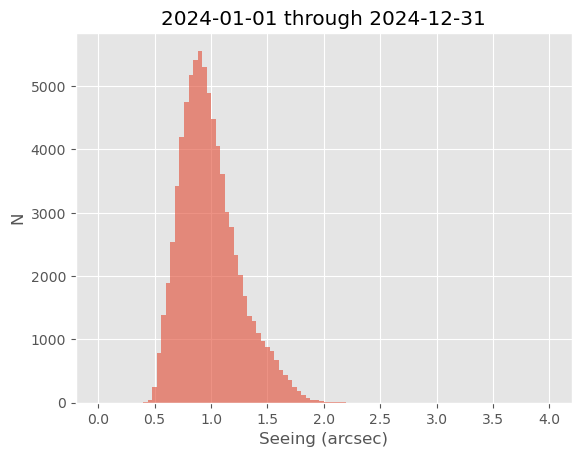

In [7]:
# make raw histogram of the zenith-corrected seeing column
fig = plt.figure(figsize=(8, 5))
fixed.hist(column='vlt_seeing', bins=100, range=(0.0, 4.0), alpha=0.6)
with plt.style.context('ggplot'):
    plt.title("2024-01-01 through 2024-12-31")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("N")
plt.show()

In [9]:
# fit a log-normal distribution to the seeing data
sigma, loc, exp_mu = lognorm.fit(fixed['vlt_seeing'])
print(sigma, loc, exp_mu)
x = np.arange(0.0, 4.0, 0.01)
p = lognorm.pdf(x, sigma, loc=loc, scale=exp_mu)
mu = np.log(exp_mu)
mode = np.exp(mu - sigma**2) + loc
median = np.nanmedian(fixed['vlt_seeing'])
fit_median = exp_mu + loc

0.30955008626182645 0.1608279372920436 0.7916368931236953


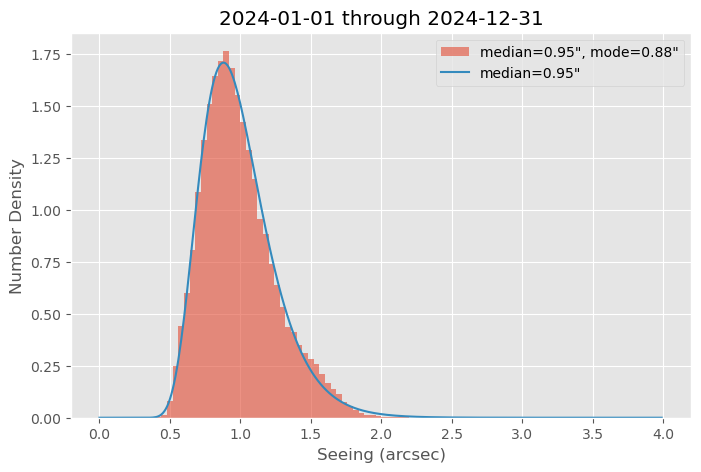

In [10]:
# plot normalized histogram with the fit and the median/mode calculated from the fit.
fig = plt.figure(figsize=(8, 5))
with plt.style.context('ggplot'):
    plt.hist(fixed['vlt_seeing'], density=True, bins=100, range=(0.0, 4.0), label="hist", alpha=0.6)
    logp = plt.plot(x, p, label="logp")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("Number Density")
    plt.title("2024-01-01 through 2024-12-31")
    plt.legend(["median=%.2f\", mode=%.2f\"" % (fit_median, mode), "median=%.2f\"" % (
        median
    )])
    plt.savefig("2024_allyear.png")
plt.show()

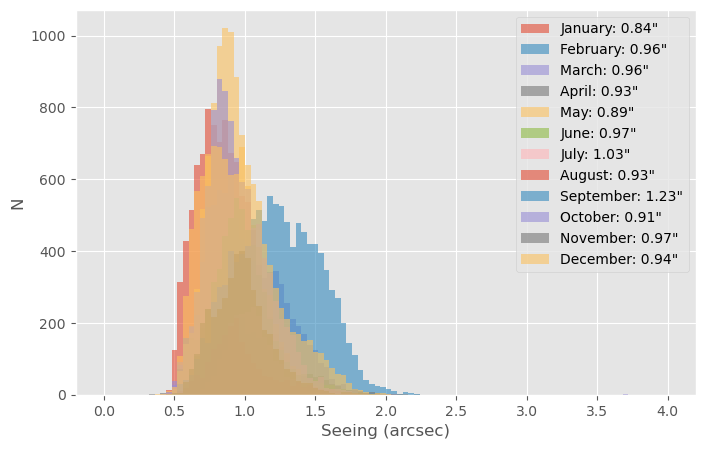

In [11]:
# panda time indexing makes it easy to group by month
fig = plt.figure(figsize=(8, 5))
months = {}
legends = []
months['January'] = fixed.loc['2024-01']
months['February'] = fixed.loc['2024-02']
months['March'] = fixed.loc['2024-03']
months['April'] = fixed.loc['2024-04']
months['May'] = fixed.loc['2024-05']
months['June'] = fixed.loc['2024-06']
months['July'] = fixed.loc['2024-07']
months['August'] = fixed.loc['2024-08']
months['September'] = fixed.loc['2024-09']
months['October'] = fixed.loc['2024-10']
months['November'] = fixed.loc['2024-11']
months['December'] = fixed.loc['2024-12']
for m in months:
    plt.hist(months[m]['vlt_seeing'], bins=100, range=(0.0, 4.0), label=m, alpha=0.6)
    legend = "%s: %.2f\"" % (m, np.median(months[m]['vlt_seeing']))
    legends.append(legend)
plt.legend(legends)
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by month")
plt.savefig("2024_monthly.png")
plt.show()

In [13]:
# now use the between_time() method to split the data into first and second halves of the night.
first_half = fixed.between_time(start_time='00:00', end_time='07:00')
second_half = fixed.between_time(start_time='07:00', end_time='14:00')
#first_half = months['December'].between_time(start_time='00:00', end_time='07:00')
#second_half = months['December'].between_time(start_time='07:00', end_time='14:00')
med_1st = np.median(first_half['vlt_seeing'])
med_2nd = np.median(second_half['vlt_seeing'])

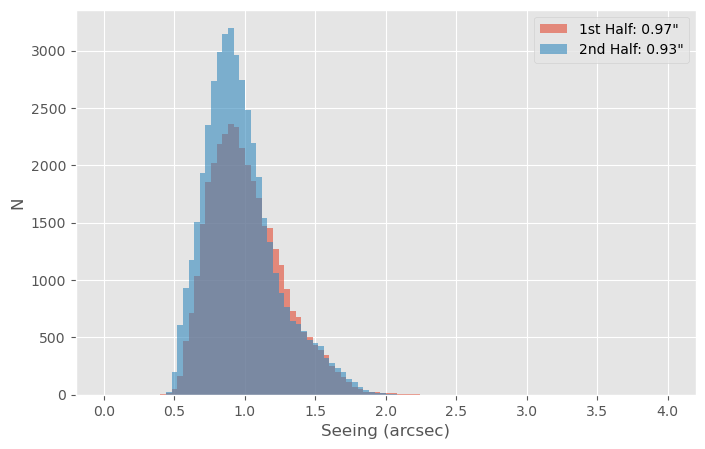

In [14]:
# plot the results and show that the seeing is better later in the night...
fig = plt.figure(figsize=(8, 5))
plt.hist(first_half['vlt_seeing'], bins=100, range=(0.0, 4.0), label="1st", alpha=0.6)
plt.hist(second_half['vlt_seeing'], bins=100, range=(0.0, 4.0), label="2nd", alpha=0.6)
plt.legend(["1st Half: %.2f\"" % med_1st, "2nd Half: %.2f\"" % med_2nd])
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by half of the night")
plt.savefig("2024_1st2nd.png")
plt.show()

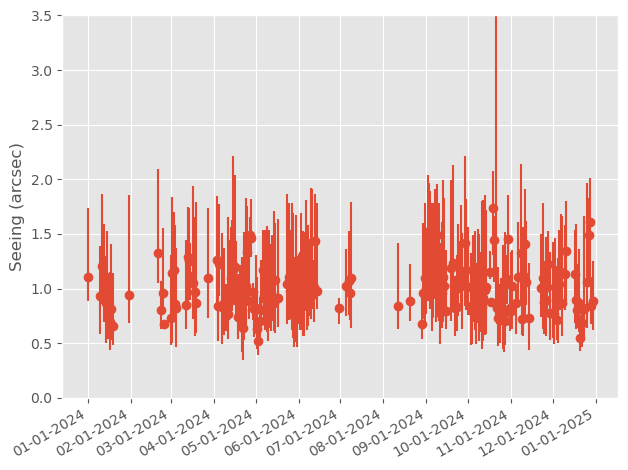

In [15]:
import matplotlib.dates as mdates

# make a new data frame that resamples the WFS data daily into the median, min, and max seeing for each day.
#fixed = fixed["2018-06-30":"2018-10-01"]
fig, ax = plt.subplots()
daily = pd.DataFrame()
daily['seeing'] = fixed.vlt_seeing.resample('D').median()
daily['max'] = fixed.vlt_seeing.resample('D').max()
daily['min'] = fixed.vlt_seeing.resample('D').min()
lowb = daily['seeing'] - daily['min']
upb = daily['max'] - daily['seeing']
plt.errorbar(daily.index, daily['seeing'], yerr=[lowb, upb], fmt='o')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%Y"))
ax.set_ylim(0.0, 3.5)
fig.autofmt_xdate()
plt.tight_layout()
plt.ylabel("Seeing (arcsec)")
#plt.title("Nightly median seeing")
plt.savefig("2024_nightly.png")
plt.show()

In [17]:
date_list = list(daily.index.strftime('%Y-%m-%d'))
data = [np.array(fixed.loc[date]['vlt_seeing']) for date in date_list]
ellipticity_data = [np.array(fixed.loc[date]['ellipticity']) for date in date_list]
clean_data = {}
clean_ellipticity = {}
for d, arr in zip(date_list, data):
    if len(arr) > 0:
        clean_data[d] = arr
for d, arr in zip(date_list, ellipticity_data):
    if len(arr) > 0:
        clean_ellipticity[d] = arr
date_labels = [datetime.strptime(d, "%Y-%m-%d").date() for d in clean_data.keys()]

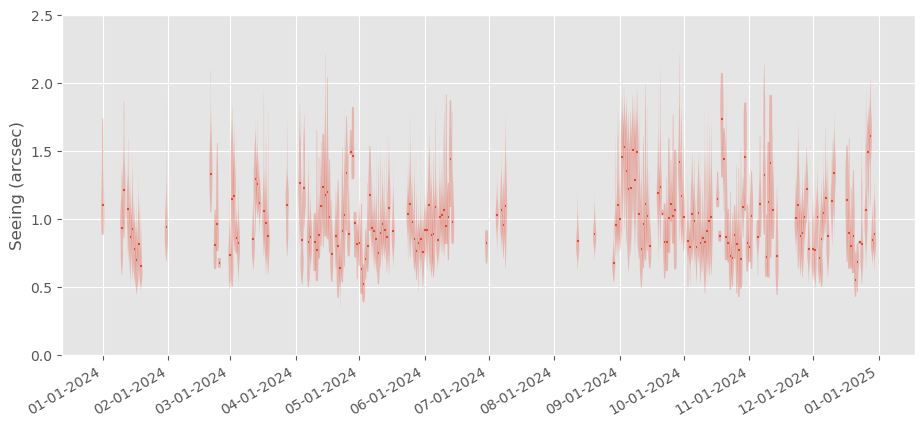

In [19]:
with plt.style.context('ggplot', after_reset=True):
    fig, ax = plt.subplots(figsize=(11,5))
    plt.violinplot(clean_data.values(), mdates.date2num(date_labels), points=50, widths=1.5,
                showextrema=False, showmedians=True, bw_method='silverman')

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%Y"))
    fig.autofmt_xdate()
    ax.set_ylim(0.0, 2.5)
    plt.ylabel("Seeing (arcsec)")
    plt.savefig("2024_violin.png")
    plt.show()

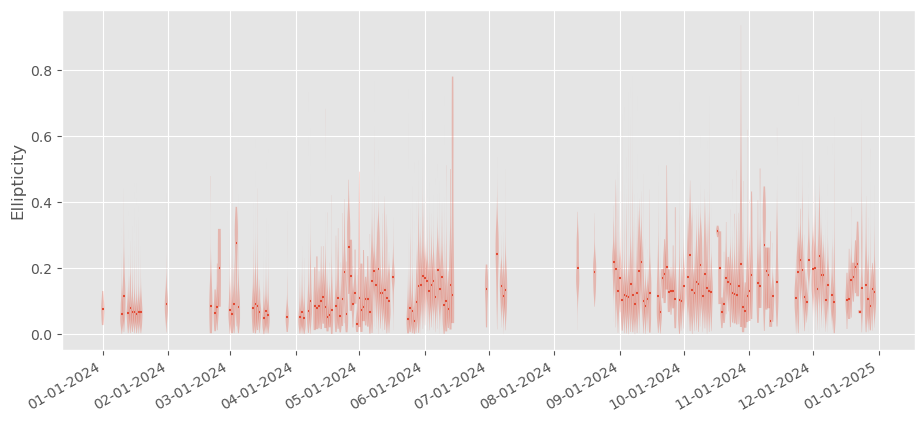

In [20]:
with plt.style.context('ggplot', after_reset=True):
    fig, ax = plt.subplots(figsize=(11,5))
    plt.violinplot(clean_ellipticity.values(), mdates.date2num(date_labels), points=50, widths=1.5,
                showextrema=False, showmedians=True, bw_method='silverman')

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%Y"))
    fig.autofmt_xdate()
    plt.ylabel("Ellipticity")
    plt.savefig("2024_ellip_violin.png")
    plt.show()

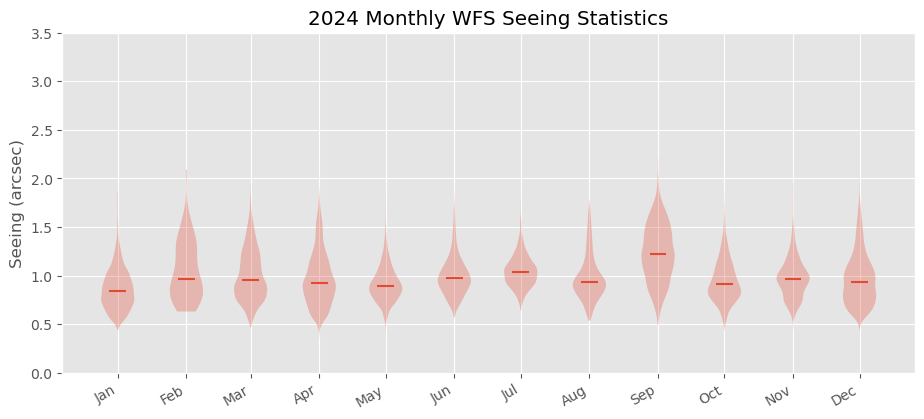

In [21]:
months = sorted(list(set(daily.index.strftime('%Y-%m'))))
mdata = [np.array(fixed.loc[month]['vlt_seeing']) for month in months]
clean_data = {}
for d, arr in zip(months, mdata):
    if len(arr) > 0:
        clean_data[d] = arr
date_labels = [datetime.strptime(d, "%Y-%m").date() for d in clean_data.keys()]

with plt.style.context('ggplot', after_reset=True):
    fig, ax = plt.subplots(figsize=(11,5))
    plt.violinplot(clean_data.values(), mdates.date2num(date_labels), points=100, widths=15,
                showextrema=False, showmedians=True, bw_method='silverman')

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.set_ylim(0.0, 3.5)
    fig.autofmt_xdate()
    plt.ylabel("Seeing (arcsec)")
    plt.savefig("2024_violin_monthly.png")
    plt.title("2024 Monthly WFS Seeing Statistics")
    plt.show()

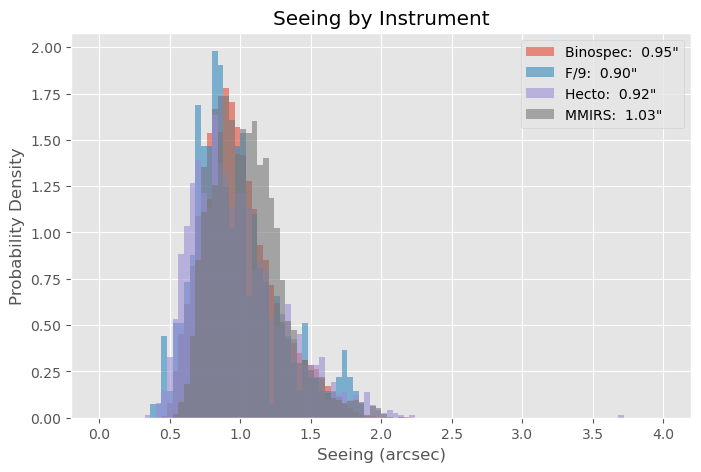

In [22]:
with plt.style.context('ggplot'):
    fig = plt.figure(figsize=(8, 5))
    medb = np.median(fixed['vlt_seeing'][fixed['wfs'] == 'binospec'])
    med9 = np.median(fixed['vlt_seeing'][fixed['wfs'] == 'newf9'])
    medf = np.median(fixed['vlt_seeing'][fixed['wfs'] == 'f5'])
    medm = np.median(fixed['vlt_seeing'][fixed['wfs'] == 'mmirs'])
    plt.hist(fixed['vlt_seeing'][fixed['wfs'] == 'binospec'], density=True, bins=100, range=(0.0, 4.), alpha=0.6, label=f"Binospec: {medb: .2f}\"")
    plt.hist(fixed['vlt_seeing'][fixed['wfs'] == 'newf9'], density=True, bins=100, range=(0.0, 4.), alpha=0.6, label=f"F/9: {med9: .2f}\"")
    plt.hist(fixed['vlt_seeing'][fixed['wfs'] == 'f5'], density=True, bins=100, range=(0.0, 4.), alpha=0.6, label=f"Hecto: {medf: .2f}\"")
    plt.hist(fixed['vlt_seeing'][fixed['wfs'] == 'mmirs'], density=True, bins=100, range=(0.0, 4.), alpha=0.6, label=f"MMIRS: {medm: .2f}\"")
    plt.legend()
    plt.title("Seeing by Instrument")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("Probability Density")
plt.savefig("per_instrument_2024.png")
plt.show()

In [23]:
from minicyclop.io import read_seeing_data

In [24]:
cyclop = read_seeing_data(Path.home() / "MMT/minicyclop/data/MiniCyclop/Data/Seeing_Data.txt")

In [25]:
cyclop

,UT,flux,seeing,r0,isot,epoch_ms
ut,,,,,,
2022-06-08 03:32:32,6/8/2022 3:32:32 AM,2733.7,0.84,135.8,2022-06-08T03:32:32.968,1654659152968
2022-06-08 03:33:27,6/8/2022 3:33:27 AM,2755.7,0.84,134.4,2022-06-08T03:33:27.409,1654659207408
2022-06-08 03:34:23,6/8/2022 3:34:23 AM,2801.6,2.38,47.7,2022-06-08T03:34:23.655,1654659263655
2022-06-08 03:35:16,6/8/2022 3:35:16 AM,2853.2,1.01,112.3,2022-06-08T03:35:16.325,1654659316324
2022-06-08 03:36:00,6/8/2022 3:36:00 AM,2739.0,1.03,110.7,2022-06-08T03:36:00.691,1654659360691
...,...,...,...,...,...,...
2025-02-08 06:37:28,2/8/2025 6:37:28 AM,1560.5,0.82,137.7,2025-02-08T06:37:28.007,1738996648007
2025-02-08 06:38:14,2/8/2025 6:38:14 AM,1484.8,0.62,183.9,2025-02-08T06:38:14.421,1738996694421
2025-02-08 06:39:00,2/8/2025 6:39:00 AM,1549.0,0.79,144.3,2025-02-08T06:39:00.913,1738996740912


In [26]:
cyclop_2024 = cyclop[(cyclop.index >= '2024-01-01') & (cyclop.index < '2025-01-01')]

0.47364598207683006 0.36812546901423854 0.6702448516683841


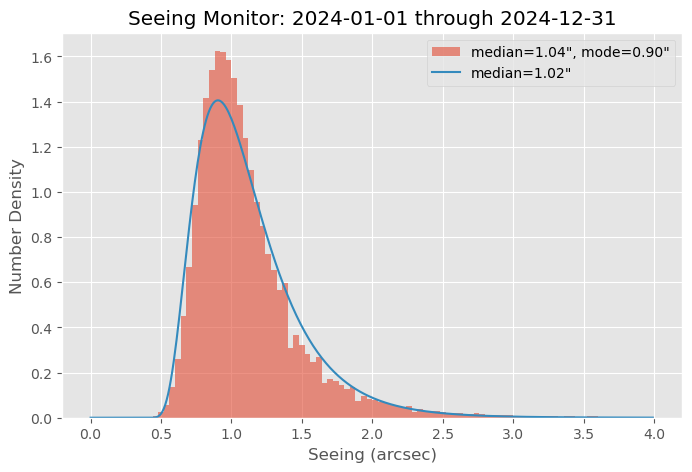

In [27]:
# fit a log-normal distribution to the seeing data
sigma, loc, exp_mu = lognorm.fit(cyclop_2024['seeing'])
print(sigma, loc, exp_mu)
x = np.arange(0.0, 4.0, 0.01)
p = lognorm.pdf(x, sigma, loc=loc, scale=exp_mu)
mu = np.log(exp_mu)
mode = np.exp(mu - sigma**2) + loc
median = np.nanmedian(cyclop_2024['seeing'])
fit_median = exp_mu + loc

# plot normalized histogram with the fit and the median/mode calculated from the fit.
fig = plt.figure(figsize=(8, 5))
with plt.style.context('ggplot'):
    plt.hist(cyclop_2024['seeing'], density=True, bins=100, range=(0.0, 4.0), label="hist", alpha=0.6)
    logp = plt.plot(x, p, label="logp")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("Number Density")
    plt.title("Seeing Monitor: 2024-01-01 through 2024-12-31")
    plt.legend(["median=%.2f\", mode=%.2f\"" % (fit_median, mode), "median=%.2f\"" % (
        median
    )])
    plt.savefig("2024_cyclop_hist.png")
plt.show()

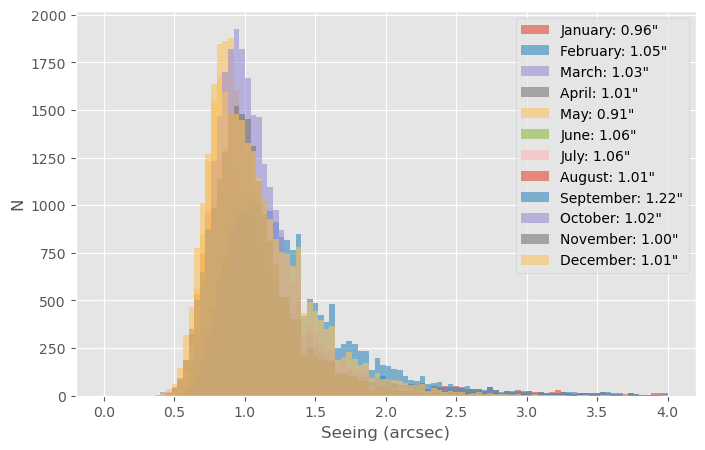

In [28]:
# panda time indexing makes it easy to group by month
fig = plt.figure(figsize=(8, 5))
cyc_months = {}
legends = []
cyc_months['January'] = cyclop_2024.loc['2024-01']
cyc_months['February'] = cyclop_2024.loc['2024-02']
cyc_months['March'] = cyclop_2024.loc['2024-03']
cyc_months['April'] = cyclop_2024.loc['2024-04']
cyc_months['May'] = cyclop_2024.loc['2024-05']
cyc_months['June'] = cyclop_2024.loc['2024-06']
cyc_months['July'] = cyclop_2024.loc['2024-07']
cyc_months['August'] = cyclop_2024.loc['2024-08']
cyc_months['September'] = cyclop_2024.loc['2024-09']
cyc_months['October'] = cyclop_2024.loc['2024-10']
cyc_months['November'] = cyclop_2024.loc['2024-11']
cyc_months['December'] = cyclop_2024.loc['2024-12']
for m in cyc_months.keys():
    plt.hist(cyc_months[m]['seeing'], bins=100, range=(0.0, 4.0), label=m, alpha=0.6)
    legend = "%s: %.2f\"" % (m, np.median(cyc_months[m]['seeing']))
    legends.append(legend)
plt.legend(legends)
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by month")
plt.savefig("2024_cyclop_monthly.png")
plt.show()

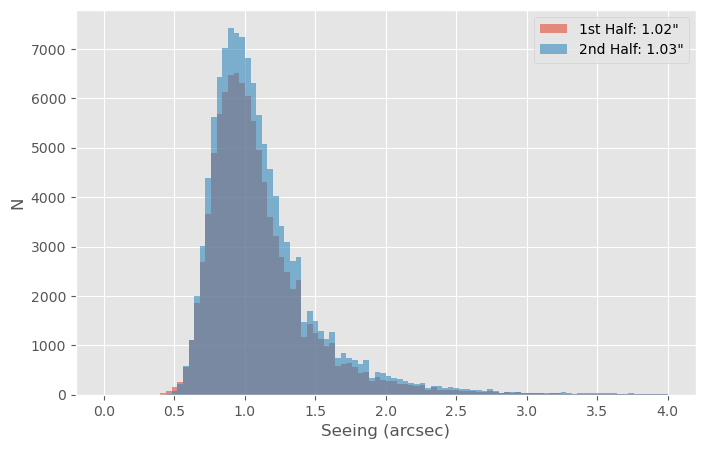

In [29]:
# now use the between_time() method to split the data into first and second halves of the night.
first_half = cyclop_2024.between_time(start_time='00:00', end_time='07:00')
second_half = cyclop_2024.between_time(start_time='07:00', end_time='14:00')
#first_half = months['December'].between_time(start_time='00:00', end_time='07:00')
#second_half = months['December'].between_time(start_time='07:00', end_time='14:00')
med_1st = np.median(first_half['seeing'])
med_2nd = np.median(second_half['seeing'])

# plot the results and show that the seeing is better later in the night...
fig = plt.figure(figsize=(8, 5))
plt.hist(first_half['seeing'], bins=100, range=(0.0, 4.0), label="1st", alpha=0.6)
plt.hist(second_half['seeing'], bins=100, range=(0.0, 4.0), label="2nd", alpha=0.6)
plt.legend(["1st Half: %.2f\"" % med_1st, "2nd Half: %.2f\"" % med_2nd])
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by half of the night")
plt.savefig("2024_cyclop_1st2nd.png")
plt.show()

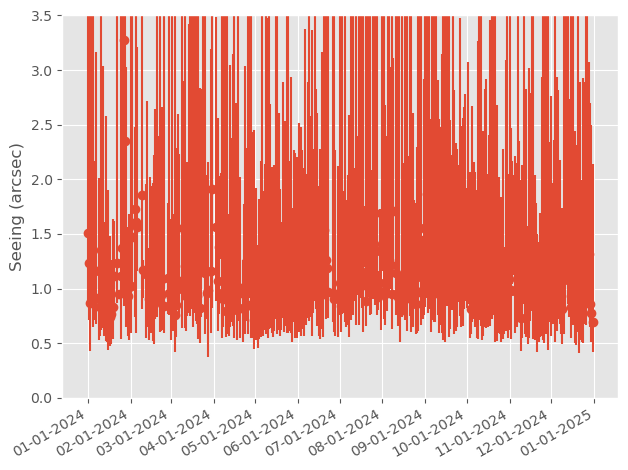

In [30]:
# make a new data frame that resamples the WFS data daily into the median, min, and max seeing for each day.
#fixed = fixed["2018-06-30":"2018-10-01"]
fig, ax = plt.subplots()
daily = pd.DataFrame()
daily['seeing'] = cyclop_2024.seeing.resample('D').median()
daily['max'] = cyclop_2024.seeing.resample('D').max()
daily['min'] = cyclop_2024.seeing.resample('D').min()
lowb = daily['seeing'] - daily['min']
upb = daily['max'] - daily['seeing']
plt.errorbar(daily.index, daily['seeing'], yerr=[lowb, upb], fmt='o')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%Y"))
ax.set_ylim(0.0, 3.5)
fig.autofmt_xdate()
plt.tight_layout()
plt.ylabel("Seeing (arcsec)")
#plt.title("Nightly median seeing")
plt.savefig("2024_cyclop_plot_monthly.png")
plt.show()

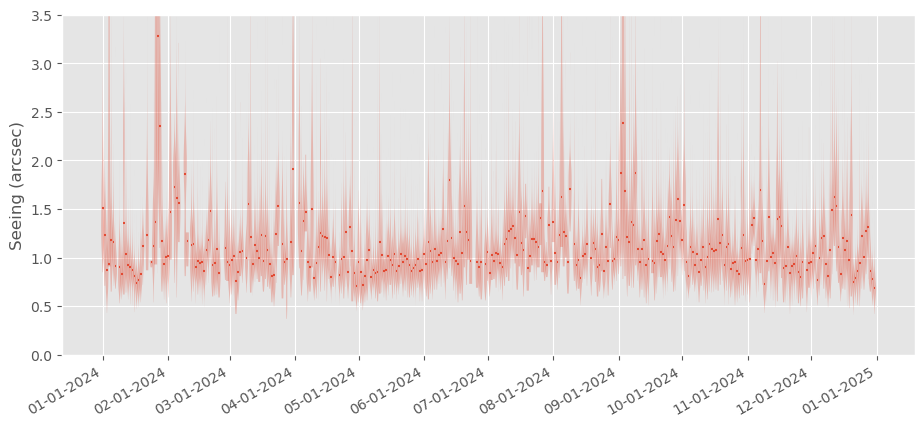

In [31]:
date_list = list(daily.index.strftime('%Y-%m-%d'))
data = [np.array(cyclop_2024.loc[date]['seeing']) for date in date_list]
clean_data = {}
for d, arr in zip(date_list, data):
    if len(arr) > 0:
        clean_data[d] = arr
date_labels = [datetime.strptime(d, "%Y-%m-%d").date() for d in clean_data.keys()]

with plt.style.context('ggplot', after_reset=True):
    fig, ax = plt.subplots(figsize=(11,5))
    plt.violinplot(clean_data.values(), mdates.date2num(date_labels), points=50, widths=1.5,
                showextrema=False, showmedians=True, bw_method='silverman')

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%Y"))
    ax.set_ylim(0.0, 3.5)
    fig.autofmt_xdate()
    plt.ylabel("Seeing (arcsec)")
    plt.savefig("2024_cyclop_violin.png")
    plt.show()

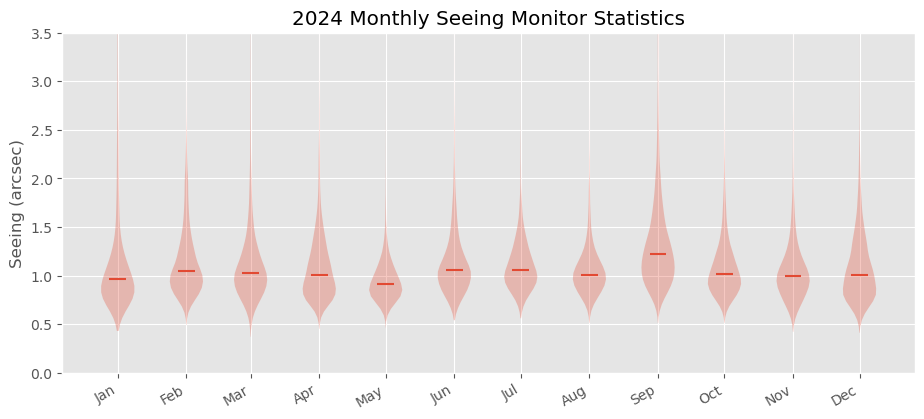

In [32]:
months = sorted(list(set(daily.index.strftime('%Y-%m'))))
mdata = [np.array(cyclop_2024.loc[month]['seeing']) for month in months]
clean_data = {}
for d, arr in zip(months, mdata):
    if len(arr) > 0:
        clean_data[d] = arr
date_labels = [datetime.strptime(d, "%Y-%m").date() for d in clean_data.keys()]

with plt.style.context('ggplot', after_reset=True):
    fig, ax = plt.subplots(figsize=(11,5))
    plt.violinplot(clean_data.values(), mdates.date2num(date_labels), points=100, widths=15,
                showextrema=False, showmedians=True, bw_method='silverman')

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.set_ylim(0.0, 3.5)
    fig.autofmt_xdate()
    plt.ylabel("Seeing (arcsec)")
    plt.savefig("2024_cyclop_violin_monthly.png")
    plt.title("2024 Monthly Seeing Monitor Statistics")
    plt.show()

In [33]:
f9 = fixed[fixed['wfs'] == 'newf9']
bino = fixed[fixed['wfs'] == 'binospec']
hecto = fixed[fixed['wfs'] == 'f5']
mmirs = fixed[fixed['wfs'] == 'mmirs']

In [34]:
f9_dates = sorted(list(set(f9.index.strftime('%Y-%m-%d'))))
bino_dates = sorted(list(set(bino.index.strftime('%Y-%m-%d'))))
hecto_dates = sorted(list(set(hecto.index.strftime('%Y-%m-%d'))))
mmirs_dates = sorted(list(set(mmirs.index.strftime('%Y-%m-%d'))))
bino_dates, hecto_dates, f9_dates, mmirs_dates

(['2024-01-10',
  '2024-01-11',
  '2024-01-13',
  '2024-01-14',
  '2024-01-15',
  '2024-01-16',
  '2024-01-17',
  '2024-01-18',
  '2024-01-19',
  '2024-03-01',
  '2024-03-02',
  '2024-03-03',
  '2024-03-04',
  '2024-03-05',
  '2024-03-12',
  '2024-03-13',
  '2024-03-14',
  '2024-03-15',
  '2024-03-17',
  '2024-03-18',
  '2024-03-19',
  '2024-04-03',
  '2024-04-04',
  '2024-04-05',
  '2024-04-07',
  '2024-04-08',
  '2024-05-07',
  '2024-05-08',
  '2024-05-09',
  '2024-05-10',
  '2024-05-11',
  '2024-05-12',
  '2024-05-13',
  '2024-05-14',
  '2024-05-15',
  '2024-05-17',
  '2024-05-29',
  '2024-05-30',
  '2024-05-31',
  '2024-06-01',
  '2024-06-02',
  '2024-06-03',
  '2024-06-04',
  '2024-06-05',
  '2024-06-06',
  '2024-06-07',
  '2024-06-08',
  '2024-06-09',
  '2024-06-10',
  '2024-07-05',
  '2024-07-07',
  '2024-07-08',
  '2024-07-09',
  '2024-08-12',
  '2024-08-20',
  '2024-08-29',
  '2024-08-30',
  '2024-08-31',
  '2024-09-01',
  '2024-09-02',
  '2024-09-03',
  '2024-09-04',
  '2024-

In [35]:
cyc_f9 = np.hstack([np.array(cyclop_2024.loc[date]['seeing']) for date in f9_dates])
cyc_bino = np.hstack([np.array(cyclop_2024.loc[date]['seeing']) for date in bino_dates])
cyc_hecto = np.hstack([np.array(cyclop_2024.loc[date]['seeing']) for date in hecto_dates])
cyc_mmirs = np.hstack([np.array(cyclop_2024.loc[date]['seeing']) for date in mmirs_dates])

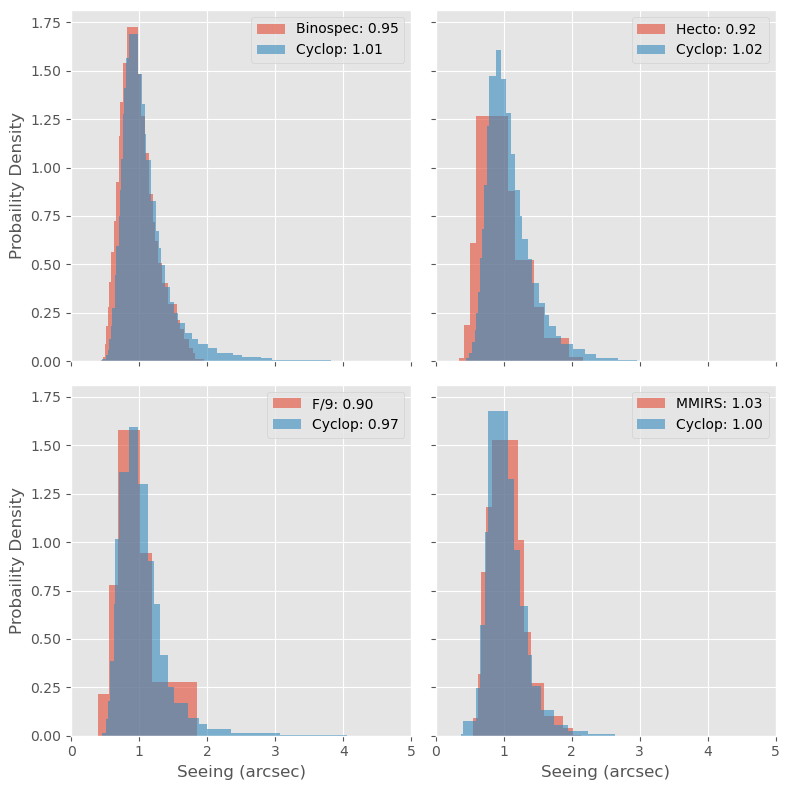

In [45]:
with plt.style.context('ggplot', after_reset=False):
    fig, ax = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
    ax = ax.flat
    fig.subplots_adjust(hspace=0)

    bin_type = "blocks"

    hist(bino['vlt_seeing'], bins=bin_type, ax=ax[0], histtype='stepfilled', alpha=0.6, density=True)
    hist(cyc_bino, bins=bin_type, ax=ax[0], histtype='stepfilled', alpha=0.6, density=True)
    ax[0].legend([f"Binospec: {np.median(bino['vlt_seeing']):.2f}", f"Cyclop: {np.median(cyc_bino):.2f}"])
    ax[0].set_ylabel("Probaility Density")
    ax[0].set_xlim(0, 5)

    hist(hecto['vlt_seeing'], bins=bin_type, ax=ax[1], histtype='stepfilled', alpha=0.6, density=True)
    hist(cyc_hecto, bins=bin_type, ax=ax[1], histtype='stepfilled', alpha=0.6, density=True)
    ax[1].legend([f"Hecto: {np.median(hecto['vlt_seeing']):.2f}", f"Cyclop: {np.median(cyc_hecto):.2f}"])
    ax[1].set_xlim(0, 5)

    hist(f9['vlt_seeing'], bins=bin_type, ax=ax[2], histtype='stepfilled', alpha=0.6, density=True)
    hist(cyc_f9, bins=bin_type, ax=ax[2], histtype='stepfilled', alpha=0.6, density=True)
    ax[2].legend([f"F/9: {np.median(f9['vlt_seeing']):.2f}", f"Cyclop: {np.median(cyc_f9):.2f}"])
    ax[2].set_xlim(0, 5)
    ax[2].set_xlabel("Seeing (arcsec)")
    ax[2].set_ylabel("Probaility Density")

    hist(mmirs['vlt_seeing'], bins=bin_type, ax=ax[3], histtype='stepfilled', alpha=0.6, density=True)
    hist(cyc_mmirs, bins=bin_type, ax=ax[3], histtype='stepfilled', alpha=0.6, density=True)
    ax[3].legend([f"MMIRS: {np.median(mmirs['vlt_seeing']):.2f}", f"Cyclop: {np.median(cyc_mmirs):.2f}"])
    ax[3].set_xlim(0, 5)
    ax[3].set_xlabel("Seeing (arcsec)")

    plt.tight_layout()
    plt.savefig("2024_cyclop_vs_inst.png")
    plt.show()

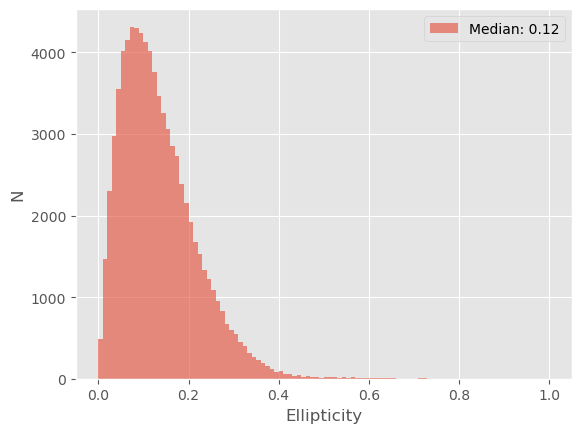

In [46]:
plt.hist(fixed['ellipticity'], bins=100, range=(0.0, 1.0), alpha=0.6, label=f"Median: {np.median(fixed['ellipticity']):.2f}")
plt.xlabel("Ellipticity")
plt.ylabel("N")
plt.legend()
plt.savefig("ellipticity_2024.png")
plt.show()


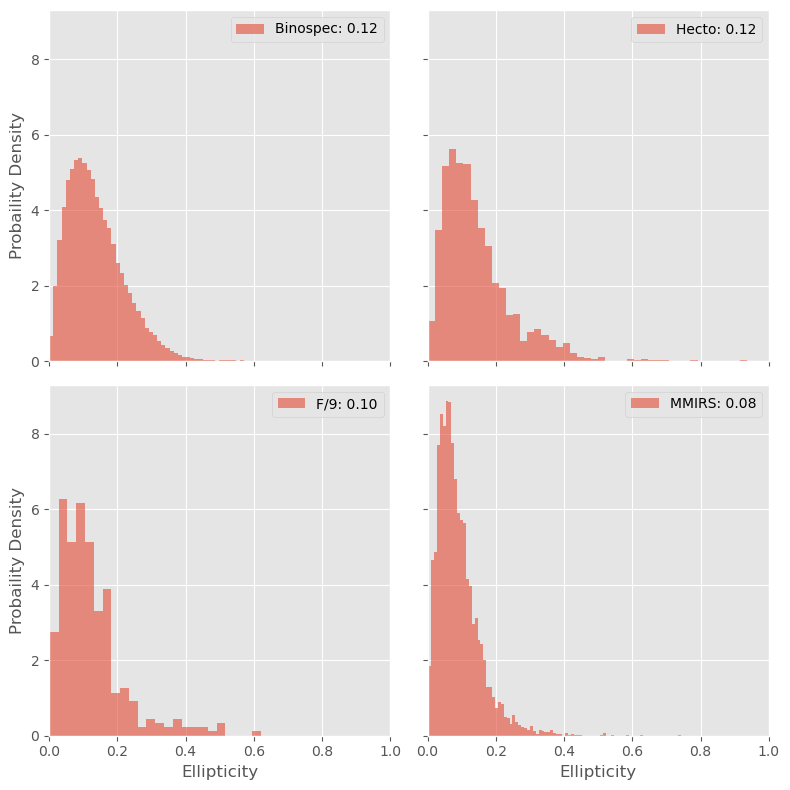

In [49]:
with plt.style.context('ggplot', after_reset=False):
    fig, ax = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
    ax = ax.flat
    fig.subplots_adjust(hspace=0)

    bin_type = "knuth"

    hist(bino['ellipticity'], bins=bin_type, ax=ax[0], histtype='stepfilled', alpha=0.6, density=True)
    ax[0].legend([f"Binospec: {np.median(bino['ellipticity']):.2f}"])
    ax[0].set_ylabel("Probaility Density")
    ax[0].set_xlim(0, 1)

    hist(hecto['ellipticity'], bins=bin_type, ax=ax[1], histtype='stepfilled', alpha=0.6, density=True)
    ax[1].legend([f"Hecto: {np.median(hecto['ellipticity']):.2f}"])
    ax[1].set_xlim(0, 1)

    hist(f9['ellipticity'], bins=bin_type, ax=ax[2], histtype='stepfilled', alpha=0.6, density=True)
    ax[2].legend([f"F/9: {np.median(f9['ellipticity']):.2f}"])
    ax[2].set_xlim(0, 1)
    ax[2].set_xlabel("Ellipticity")
    ax[2].set_ylabel("Probaility Density")

    hist(mmirs['ellipticity'], bins=bin_type, ax=ax[3], histtype='stepfilled', alpha=0.6, density=True)
    ax[3].legend([f"MMIRS: {np.median(mmirs['ellipticity']):.2f}"])
    ax[3].set_xlim(0, 1)
    ax[3].set_xlabel("Ellipticity")

    plt.tight_layout()
    plt.savefig("2024_ellip_vs_inst.png")
    plt.show()